# iminuit and automatic differentiation with JAX

iminuit's minimization algorithm MIGRAD uses a mix of gradient descent and Newton's method to find the minimum. Both require a first derivative, which MIGRAD usually computes numerically from finite differences. This requires many function evaluations and the gradient may not be accurate. As an alternative, iminuit also allows the user to compute the gradient and pass it to MIGRAD.

Although computing derivatives is often straight-forward, it is usually too much hassle to do manually. Automatic differentiation (AD) is an interesting alternative, it allows one to compute exact derivatives efficiently for pure Python/numpy functions. We demonstrate automatic differentiation with the JAX module, which can not only compute derivatives, but also accelerates the computation of Python code (including the gradient code) with a just-in-time compiler.

[Recommended read: Gentle introduction to AD](https://www.kaggle.com/borisettinger/gentle-introduction-to-automatic-differentiation)

## Example A: Fit of a gaussian model to a histogram

We are going to fit a gaussian to a histogram using a maximum-likelihood approach based on Poisson statistics. This example is used to investigate how automatic differentiation can accelerate a typical fit in a counting experiment.

In [19]:
# !pip install jax jaxlib

from jax.config import config
config.update("jax_enable_x64", True) # enable float64 precision
from jax import numpy as np # replacement for normal numpy
from jax.scipy.special import erf
from jax import jit, grad
from iminuit import Minuit

import numpy as onp # original numpy
from numpy.random import default_rng

In [20]:
# generate some toy data
rng = default_rng(seed=1)
w, xe = onp.histogram(rng.normal(0, 1, 10000), bins=1000)


# define the model and the score function to minimize
def pdf(x, par):
    mu, sigma = par
    z = (x - mu) / sigma
    return np.exp(-0.5 * z ** 2) / ((2 * np.pi) ** 0.5 * sigma)


def cdf(x, par):
    mu, sigma = par
    z = (x - mu) / sigma
    return 0.5 * (1 + erf(z / np.sqrt(2)))


def score(par):
    amp = par[0]
    rest = par[1:]
    mu = amp * (cdf(xe[1:], rest) - cdf(xe[:-1], rest))
    result = 2 * np.sum(mu - w * np.log(mu + 1e-100))
    return result

Let's check results from all combinations of using JIT and gradient and then compare the execution times.

|      |     |     |
|:----:|:---:|:---:|
|      |~JIT~| JIT |
|~grad~| m1  | m3  |
| grad | m2  | m4  |

In [21]:
start_values = (1.5 * np.sum(w), 1.0, 2.0)
limits = ((0, None), None, (0, None))

In [22]:
m1 = Minuit.from_array_func(score, start_values,
                            limit=limits, pedantic=False)
m1.strategy = 0
m1.migrad()

------------------------------------------------------------------
| FCN = -3.871E+04              |      Ncalls=68 (68 total)      |
| EDM = 2.52E-08 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  1.000E4  |  0.010E4  |            |            |    0    |         |       |
| 1 | x1   |  -0.011   |   0.010   |            |            |         |         |       |
| 2 | x2   |   0.999   |   0.007   |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [23]:
m2 = Minuit.from_array_func(score, start_values,
                            grad=grad(score),
                            limit=limits, pedantic=False)
m2.strategy = 0
m2.migrad()

------------------------------------------------------------------
| FCN = -3.871E+04              |      Ncalls=76 (76 total)      |
| EDM = 4.43E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  1.000E4  |  0.010E4  |            |            |    0    |         |       |
| 1 | x1   |  -0.011   |   0.010   |            |            |         |         |       |
| 2 | x2   |   0.999   |   0.007   |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [24]:
m3 = Minuit.from_array_func(jit(score), start_values,
                            limit=limits, pedantic=False)
m3.strategy = 0
m3.migrad()

------------------------------------------------------------------
| FCN = -3.871E+04              |      Ncalls=68 (68 total)      |
| EDM = 2.64E-08 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  1.000E4  |  0.010E4  |            |            |    0    |         |       |
| 1 | x1   |  -0.011   |   0.010   |            |            |         |         |       |
| 2 | x2   |   0.999   |   0.007   |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [25]:
m4 = Minuit.from_array_func(jit(score), start_values,
                            grad=jit(grad(score)),
                            limit=limits, pedantic=False)
m4.strategy = 0
m4.migrad()

------------------------------------------------------------------
| FCN = -3.871E+04              |      Ncalls=76 (76 total)      |
| EDM = 4.62E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  1.000E4  |  0.010E4  |            |            |    0    |         |       |
| 1 | x1   |  -0.011   |   0.010   |            |            |         |         |       |
| 2 | x2   |   0.999   |   0.007   |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [26]:
from timeit import repeat
times = { "no JIT, no grad": "m1",
          "no JIT, grad": "m2",
          "JIT, no grad": "m3",
          "JIT, grad": "m4" }
for k, v in times.items():
    t = repeat(f"{v}.migrad()", f"from __main__ import {v}", repeat=10, number=10)
    times[k] = onp.mean(t)

Just using the JIT compiler increases the speed 12-fold.
Using JIT and gradient is a 33-fold increase.


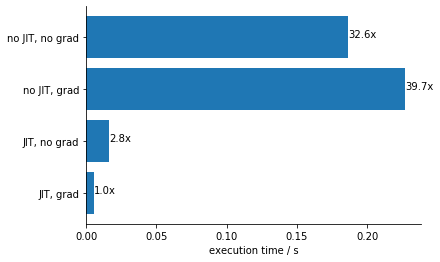

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

x = onp.fromiter(times.values(), dtype=float)
xmin = np.min(x)

y = -onp.arange(4)
plt.barh(y, x)
for yi, k, v in zip(y, times, x):
    plt.text(v, yi, f"{v/xmin:.1f}x")
plt.yticks(y, times.keys())
for loc in ("top", "right"):
    plt.gca().spines[loc].set_visible(False)
plt.xlabel("execution time / s")
print(f"""Just using the JIT compiler increases the speed {x[0]/x[2]:.0f}-fold.
Using JIT and gradient is a {x[0]/x[3]:.0f}-fold increase.""")

Conclusions:

1. Apparently, JIT-ing the gradient is important. Using a pure-Python gradient actually slows the fit down.

2. A huge speed-up can be obtained just by JIT-ing the score function.

The gain from using a gradient is larger for functions with hundreds of parameters, as is common in machine learning. Human-made models often have less than 10 parameters, and then the gain is not so dramatic. 

Finally, automatic differentiation gives us another way to compute the uncertainties of the fitted parameters. The standard method used by MINUIT to compute the uncertainties is HESSE, which computes the matrix of second derivates at the minimum and inverts this. HESSE does this computation numerically. We can check the result with an exact computation using automatic differentiation.

In [31]:
m4.hesse()
cov_hesse = m4.np_covariance()

from jax import jacfwd, jacrev
hessian = jit(jacfwd(jacrev(jit(score))))

par = m4.np_values()
cov_jax = 2 * onp.linalg.inv(hessian(par))

print(f"sigma[amp]  : HESSE = {cov_hesse[0, 0] ** 0.5:6.1f}, JAX = {cov_jax[0, 0] ** 0.5:6.1f}")
print(f"sigma[mu]   : HESSE = {cov_hesse[1, 1] ** 0.5:6.4f}, JAX = {cov_jax[1, 1] ** 0.5:6.4f}")
print(f"sigma[sigma]: HESSE = {cov_hesse[2, 2] ** 0.5:6.4f}, JAX = {cov_jax[2, 2] ** 0.5:6.4f}")

sigma[amp]  : HESSE =  100.0, JAX =  100.0
sigma[mu]   : HESSE = 0.0100, JAX = 0.0100
sigma[sigma]: HESSE = 0.0071, JAX = 0.0071


HESSE and JAX give the same answer.

## Example B: Fit data points with uncertainties in x and y

Let's say we have some data points $(x_i \pm \sigma_{x,i}, y_i \pm \sigma_{y,i})$ and we have a model $y=f(x)$ that we want to adapt to this data. If $\sigma_{x,i}$ was zero, we could use the usual least-squares method, minimizing the sum of squared residuals $r^2_i = (y_i - f(x_i))^2 / \sigma^2_{y,i}$. Here, we don't know where to evaluate $f(x)$, since the exact $x$-location is only known up to $\sigma_{x,i}$.

We can approximately extend the standard least-squares method to handle this case. We use that the uncertainty along the $x$-axis can be converted into an additional uncertainty along the $y$-axis with error propagation,
$$
f(x_i \pm \sigma_{x,i}) \simeq f(x_i) \pm f'(x_i)\,\sigma_{x,i}.
$$
Using this, we obtain modified squared residuals
$$
r^2_i = \frac{(y_i - f(x_i))^2}{\sigma^2_{y,i} + (f'(x_i) \,\sigma_{x,i})^2}.
$$

We demonstrate this with a fit of a polynomial.

In [11]:
# polynomial model
def f(x, par):
    return np.polyval(par, x)


# true polynomial f(x) = x^2 + 2 x + 3
par_true = (1, 2, 3)


# grad computes derivative with respect to the first argument
f_prime = jit(grad(f))


# checking first derivative f'(x) = 2 x + 2
assert f_prime(0.0, par_true) == 2
assert f_prime(1.0, par_true) == 4
# ok!

# generate toy data
n = 30 
data_x = np.linspace(-4, 7, n)
data_y = f(data_x, par_true)

rng = default_rng(seed=1)
sigma_x = 0.5
sigma_y = 5
data_x += rng.normal(0, sigma_x, n)
data_y += rng.normal(0, sigma_y, n)

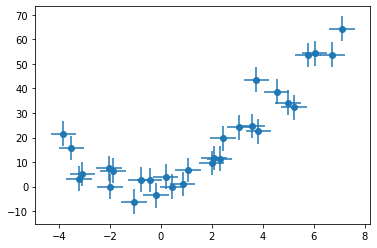

In [12]:
plt.errorbar(data_x, data_y, sigma_y, sigma_x, fmt="o");

In [13]:
# define the score function
@jit
def score(par):
    result = 0.0
    for xi, yi in zip(data_x, data_y):
        y_var = sigma_y ** 2 + (f_prime(xi, par) * sigma_x) ** 2
        result += (yi - f(xi, par)) ** 2 / y_var
    return result

# compile and test the jit-ed function
score(np.zeros(3))

DeviceArray(876.49545695, dtype=float64)

In [14]:
m = Minuit.from_array_func(score, np.zeros(3), pedantic=False)
m.migrad()

------------------------------------------------------------------
| FCN = 23.14                   |      Ncalls=84 (84 total)      |
| EDM = 1.09E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.25    |   0.15    |            |            |         |         |       |
| 1 | x1   |    1.5    |    0.5    |            |            |         |         |       |
| 2 | x2   |    1.6    |    1.5    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [15]:
par = m.np_values()
cov = m.np_covariance()

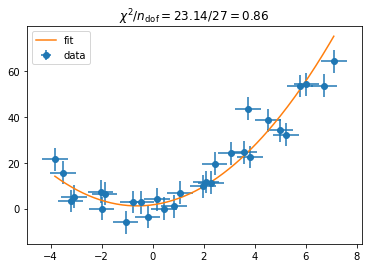

In [16]:
plt.errorbar(data_x, data_y, sigma_y, sigma_x, fmt="o", label="data")
x = np.linspace(data_x[0], data_x[-1], 200)
plt.plot(x, f(x, par), label="fit")
plt.legend()

# check fit quality
chi2 = m.fval
ndof = len(data_y) - 3
plt.title(f"$\\chi^2 / n_\\mathrm{{dof}} = {chi2:.2f} / {ndof} = {chi2/ndof:.2f}$");

We obtained a good fit.